## Title:Twitter Data Sentiment Analysis 

### Objective:
    Our objective is to build a machine learning model to classify a particular tweet wheather it's positive or not.

### Data Source: Kaggle dataset

### About dataset:
    "twitter-train.csv" - For training the models, we provide a labelled dataset of 31,962 tweets. The dataset is provided 
    in the form of a csv file with each line storing a tweet id, its label and the tweet.


    "twitter-test.csv" - The target data file contains only tweet ids and the tweet text with each tweet in a new line.

### Required Libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import model_selection, preprocessing, linear_model, metrics,pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import ensemble
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report 
from sklearn.model_selection import cross_val_score


from sklearn import set_config
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib

#!pip install wordcloud
#!pip install textblob
import re
from textblob import Word
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

### Reading Train and Test Dataset

In [2]:
%%time
train = pd.read_csv('twitter-train.csv')
target = pd.read_csv('twitter-test.csv')

Wall time: 136 ms


### Data exploration

In [3]:
#The first Ten rows of train set
train.head()

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

In [4]:
#The first Ten rows of test set
target.head()

id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...

In [5]:
#Shapes of the train and test sets
print("Train set shape: {} and target set shape: {}".format(train.shape, target.shape))

Train set shape: (31962, 3) and target set shape: (17197, 2)


In [6]:
#Get general information about train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [7]:
#Get general information about test data
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [8]:
#Check whether there are duplicated values
print("Totally there are {} duplicated values in train_set".format(train.duplicated().sum()))

Totally there are 0 duplicated values in train_set


In [9]:
#Get the number of classes of the "label" variable of train set
train.drop('id',axis=1).groupby("label").count()

tweet
label       
0      29720
1       2242

In [10]:
## Checking for null values in data.....
train.isnull().any()

id       False
label    False
tweet    False
dtype: bool

### Some Initial Visuals From Train and Target Datasets

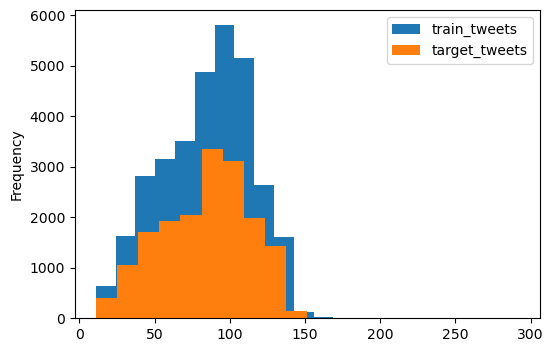

In [11]:
length_train = train['tweet'].str.len().plot.hist(bins=20, figsize = (6, 4),label='train_tweets')
length_test = target['tweet'].str.len().plot.hist(bins=20, figsize = (6, 4),label='target_tweets')
plt.legend()

In [12]:
# Percent of churned vs not-churned customers

labels = ['Negetive', 'Positive']
values = [train.label[train['label']==1].count(), train.label[train['label']==0].count()]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.1], title='Proportion of tweets Negetive and Positive')])
fig.show()

##### Observation: 
    The 'label' feature is highly imbalanced in our train data.

In [13]:
c=CountVectorizer(stop_words='english')
word=c.fit_transform(train.tweet)
summation=word.sum(axis=0)
print(summation)

[[ 51  28   2 ... 272   1   2]]


In [14]:
freq=[(word,summation[0,i]) for word,i in c.vocabulary_.items()]
freq=sorted(freq,key=lambda x:x[1],reverse=True)
frequency = pd.DataFrame(freq, columns=['word', 'freq'])
print(frequency)

           word   freq
0          user  17577
1          love   2749
2           day   2311
3           amp   1776
4         happy   1686
...         ...    ...
41099       isz      1
41100  airwaves      1
41101    mantle      1
41102   shirley      1
41103   chisolm      1

[41104 rows x 2 columns]


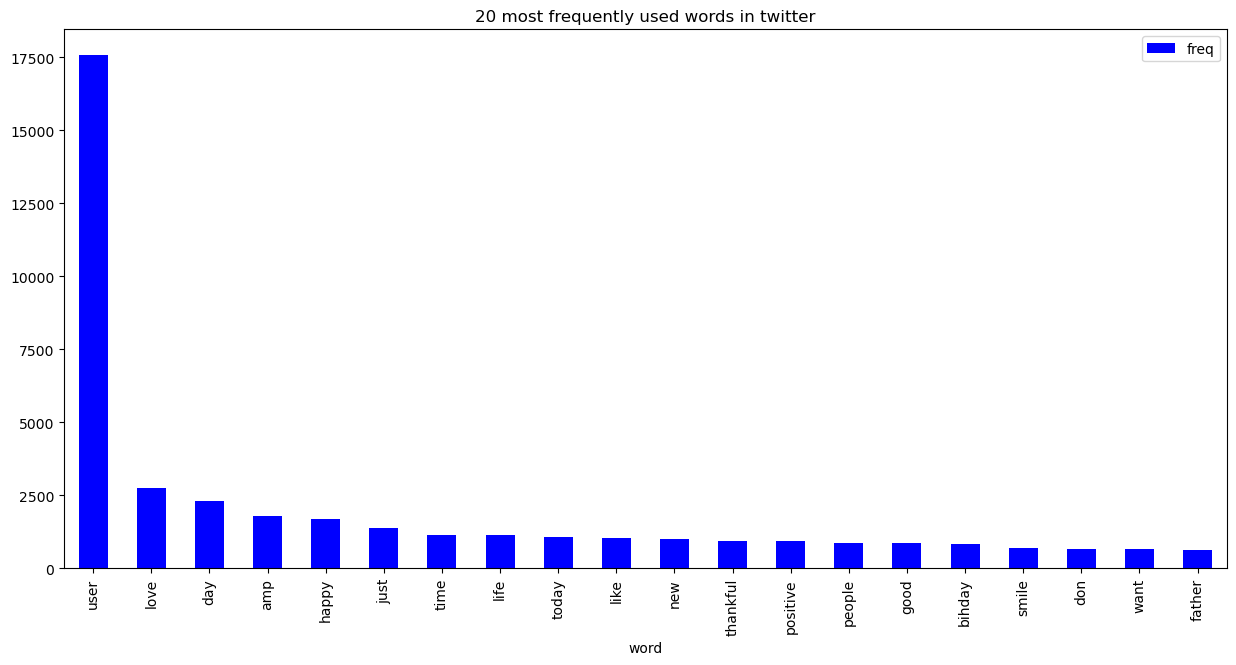

In [15]:
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("20 most frequently used words in twitter")
plt.show()

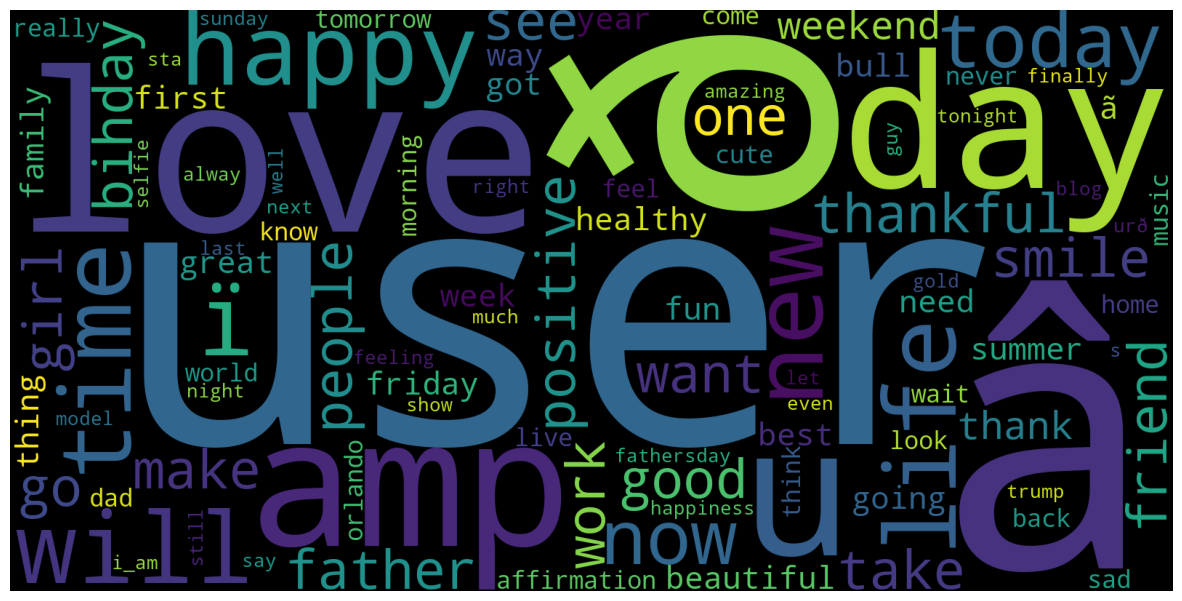

In [16]:
text = " ".join(i for i in train.tweet)

wc = WordCloud(background_color = "black",
               width = 1600,
               height = 800,
               #contour_width = 0,
               contour_color = "red",
               max_words = 100,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.axis("off")
plt.show;

### Feature Extraction & Implementaing Natural Language Processing

#### Count number of words

In [17]:
#Count number of words
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))
    print(df[['tweet','word_count']].head())

In [18]:
num_of_words(train)

                                               tweet  word_count
0   @user when a father is dysfunctional and is s...          21
1  @user @user thanks for #lyft credit i can't us...          22
2                                bihday your majesty           5
3  #model   i love u take with u all the time in ...          17
4             factsguide: society now    #motivation           8


In [19]:
num_of_words(target)

                                               tweet  word_count
0  #studiolife #aislife #requires #passion #dedic...          12
1   @user #white #supremacists want everyone to s...          20
2  safe ways to heal your #acne!!    #altwaystohe...          15
3  is the hp and the cursed child book up for res...          24
4    3rd #bihday to my amazing, hilarious #nephew...          18


#### Count number of characters

In [20]:
#Count number of characters
def num_of_chars(train):
    train['char_count'] = train['tweet'].str.len() ## this also includes spaces
    print(train[['tweet','char_count']].head())

In [21]:
num_of_chars(train)

                                               tweet  char_count
0   @user when a father is dysfunctional and is s...         102
1  @user @user thanks for #lyft credit i can't us...         122
2                                bihday your majesty          21
3  #model   i love u take with u all the time in ...          86
4             factsguide: society now    #motivation          39


In [22]:
num_of_chars(target)

                                               tweet  char_count
0  #studiolife #aislife #requires #passion #dedic...          90
1   @user #white #supremacists want everyone to s...         101
2  safe ways to heal your #acne!!    #altwaystohe...          71
3  is the hp and the cursed child book up for res...         142
4    3rd #bihday to my amazing, hilarious #nephew...          93


#### Average word length

In [23]:
def avg_word(sentence):
    words = sentence.split()    
    return (sum(len(word) for word in words)/len(words))

In [24]:
def avg_word_length(df):
    df['avg_word'] = df['tweet'].apply(lambda x: avg_word(x))
    print(df[['tweet','avg_word']].head())

In [25]:
avg_word_length(train)

                                               tweet  avg_word
0   @user when a father is dysfunctional and is s...  4.555556
1  @user @user thanks for #lyft credit i can't us...  5.315789
2                                bihday your majesty  5.666667
3  #model   i love u take with u all the time in ...  4.928571
4             factsguide: society now    #motivation  8.000000


In [26]:
avg_word_length(target)

                                               tweet  avg_word
0  #studiolife #aislife #requires #passion #dedic...  8.777778
1   @user #white #supremacists want everyone to s...  5.125000
2  safe ways to heal your #acne!!    #altwaystohe...  6.333333
3  is the hp and the cursed child book up for res...  5.409091
4    3rd #bihday to my amazing, hilarious #nephew...  5.066667


#### Number of special characters

In [27]:
def hash_tags(df):
    df['hashtags'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
    print(df[['tweet','hashtags']].head())

In [28]:
hash_tags(train)

                                               tweet  hashtags
0   @user when a father is dysfunctional and is s...         1
1  @user @user thanks for #lyft credit i can't us...         3
2                                bihday your majesty         0
3  #model   i love u take with u all the time in ...         1
4             factsguide: society now    #motivation         1


In [29]:
hash_tags(target)

                                               tweet  hashtags
0  #studiolife #aislife #requires #passion #dedic...         7
1   @user #white #supremacists want everyone to s...         4
2  safe ways to heal your #acne!!    #altwaystohe...         4
3  is the hp and the cursed child book up for res...         3
4    3rd #bihday to my amazing, hilarious #nephew...         2


#### Number of numerics

In [30]:
def num_numerics(df):
    df['numerics'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    print(df[['tweet','numerics']].head())

In [31]:
num_numerics(train)

                                               tweet  numerics
0   @user when a father is dysfunctional and is s...         0
1  @user @user thanks for #lyft credit i can't us...         0
2                                bihday your majesty         0
3  #model   i love u take with u all the time in ...         0
4             factsguide: society now    #motivation         0


In [32]:
num_numerics(target)

                                               tweet  numerics
0  #studiolife #aislife #requires #passion #dedic...         0
1   @user #white #supremacists want everyone to s...         0
2  safe ways to heal your #acne!!    #altwaystohe...         0
3  is the hp and the cursed child book up for res...         0
4    3rd #bihday to my amazing, hilarious #nephew...         0


#### Number of Uppercase words

In [33]:
def num_uppercase(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    print(df[['tweet','upper_case']].head())

In [34]:
num_uppercase(train)

                                               tweet  upper_case
0   @user when a father is dysfunctional and is s...           0
1  @user @user thanks for #lyft credit i can't us...           0
2                                bihday your majesty           0
3  #model   i love u take with u all the time in ...           0
4             factsguide: society now    #motivation           0


In [35]:
num_uppercase(target)

                                               tweet  upper_case
0  #studiolife #aislife #requires #passion #dedic...           0
1   @user #white #supremacists want everyone to s...           0
2  safe ways to heal your #acne!!    #altwaystohe...           0
3  is the hp and the cursed child book up for res...           0
4    3rd #bihday to my amazing, hilarious #nephew...           0


#### Number of stopwords

In [36]:
#set(stopwords.words('english'))

In [37]:
stop = stopwords.words('english')

In [38]:
def stop_words(df):
    df['stopwords'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
    print(df[['tweet','stopwords']].head())

In [39]:
stop_words(train)

                                               tweet  stopwords
0   @user when a father is dysfunctional and is s...         10
1  @user @user thanks for #lyft credit i can't us...          5
2                                bihday your majesty          1
3  #model   i love u take with u all the time in ...          5
4             factsguide: society now    #motivation          1


In [40]:
stop_words(target)

                                               tweet  stopwords
0  #studiolife #aislife #requires #passion #dedic...          1
1   @user #white #supremacists want everyone to s...          4
2  safe ways to heal your #acne!!    #altwaystohe...          2
3  is the hp and the cursed child book up for res...          8
4    3rd #bihday to my amazing, hilarious #nephew...          4


In [41]:
lemma=WordNetLemmatizer()

In [42]:
## Lemmatization, exclusion of stopwords, Converting uppercase letters to lowercase letters
def clean_text(tweet):
    tweets = " ".join(filter(lambda x: x[0]!= '@' , tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    #tweets = [word for word in tweets if not word in set(stopwords.words('english'))]
    tweets = [lemma.lemmatize(word) for word in tweets if not word in set(stopwords.words('english'))]
    tweets = " ".join(tweets)
    return tweets

In [43]:
train['clean_tweet'] = train.tweet.apply(clean_text)

In [44]:
target['clean_tweet'] = target.tweet.apply(clean_text)

In [45]:
train.head()

id  label                                              tweet  word_count  \
0   1      0   @user when a father is dysfunctional and is s...          21   
1   2      0  @user @user thanks for #lyft credit i can't us...          22   
2   3      0                                bihday your majesty           5   
3   4      0  #model   i love u take with u all the time in ...          17   
4   5      0             factsguide: society now    #motivation           8   

   char_count  avg_word  hashtags  numerics  upper_case  stopwords  \
0         102  4.555556         1         0           0         10   
1         122  5.315789         3         0           0          5   
2          21  5.666667         0         0           0          1   
3          86  4.928571         1         0           0          5   
4          39  8.000000         1         0           0          1   

                                         clean_tweet  
0  father dysfunctional selfish drag kid dysfunct...  
1  thanks lyft credit use cause offer wheelchair ...  
2                                     bihday majesty  
3                        model love u take u time ur  
4                      factsguide society motivation

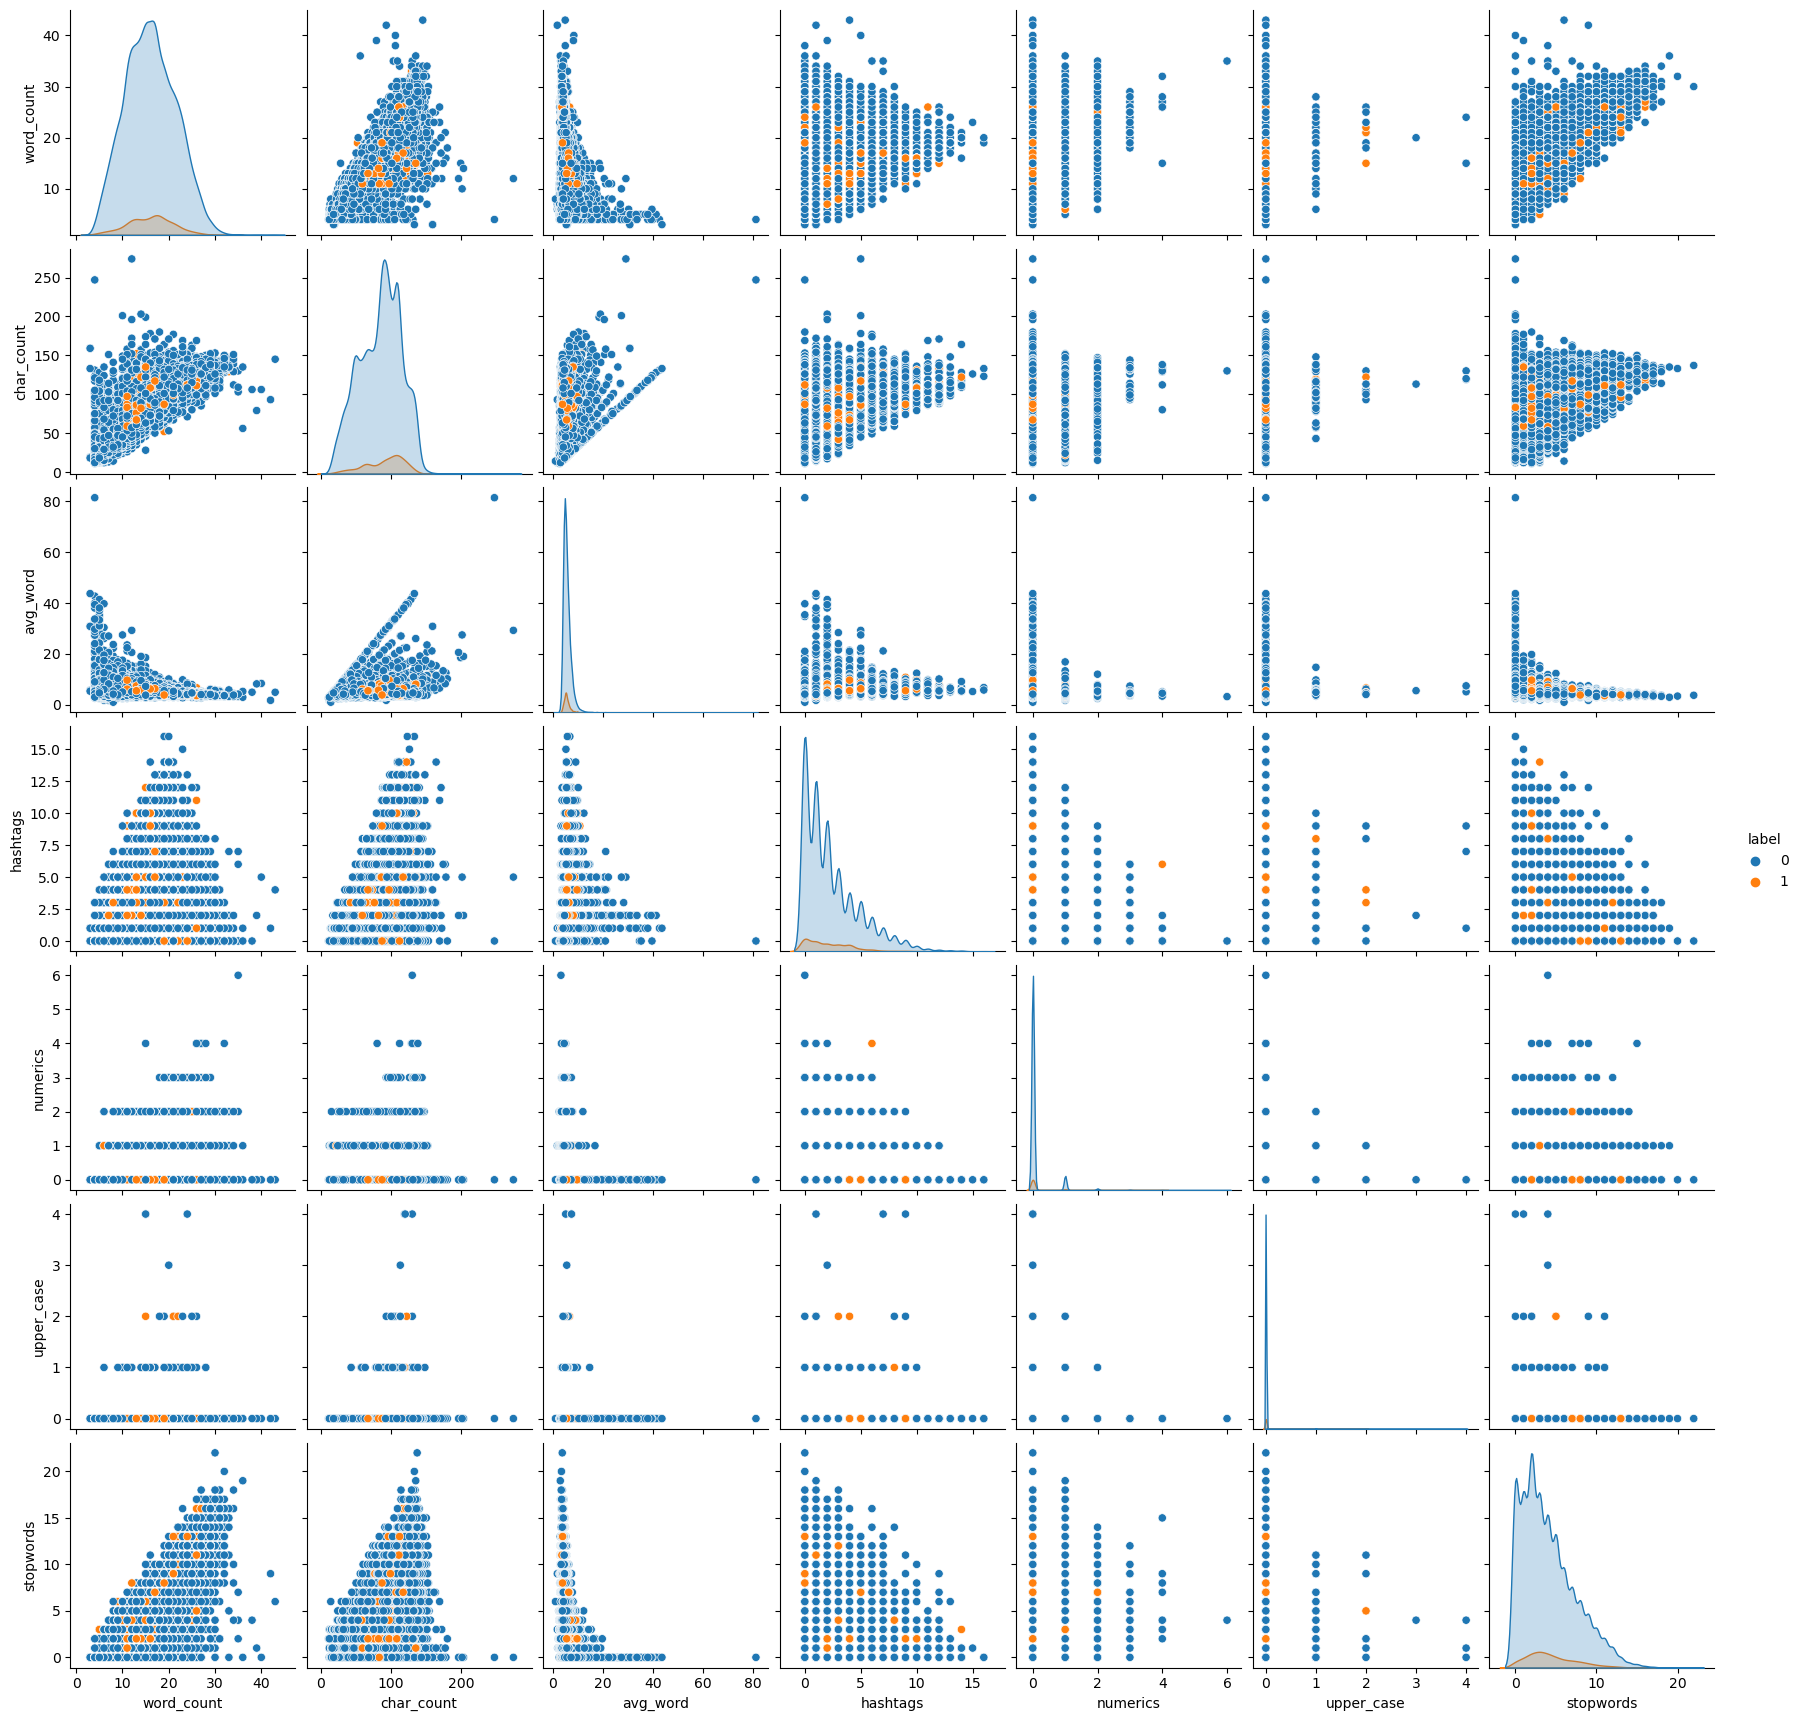

In [46]:
#Variation of each feature with respect to other features
sns.pairplot(train[['word_count','char_count','avg_word','hashtags','numerics','upper_case','stopwords','label']],hue='label')
plt.show()

### VECTORIZE DATA
##### Word Embeddings or Word vectorization in NLP is a technique where individual words are represented as real-valued vectors in a lower-dimensional space and captures inter-word semantics. Each word is represented by a real-valued vector with tens or hundreds of dimensions.


## Term frequency-inverse document frequency (TF-IDF)

Term frequency-inverse document frequency is the machine learning algorithm that is used for word embedding for text. It comprises two metrics, namely term frequency (TF) and inverse document frequency (IDF).

This algorithm works on a statistical measure of finding word relevance in the text that can be in the form of a single document or various documents that are referred to as corpus.

The term frequency (TF) score measures the frequency of words in a particular document. In simple words, it means that the occurrence of words is counted in the documents.

The inverse document frequency or the IDF score measures the rarity of the words in the text. It is given more importance over the term frequency score because even though the TF score gives more weightage to frequently occurring words, the IDF score focuses on rarely used words in the corpus that may hold significant information.

TF-IDF algorithm finds application in solving simpler natural language processing and machine learning problems for tasks like information retrieval, stop words removal, keyword extraction, and basic text analysis. However, it does not capture the semantic meaning of words efficiently in a sequence.

Now let’s understand it further, we will see how vectorization is done in TF-IDF.

TF-IDF formula.

![Example Image](https://mungingdata.files.wordpress.com/2017/11/equation.png)


To create TF-IDF vectors, we use Scikit-learn’s TF-IDF Vectorizer.

In [47]:
tfidf = TfidfVectorizer(max_features=1000,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
X = tfidf.fit_transform(train['clean_tweet'])

In [48]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

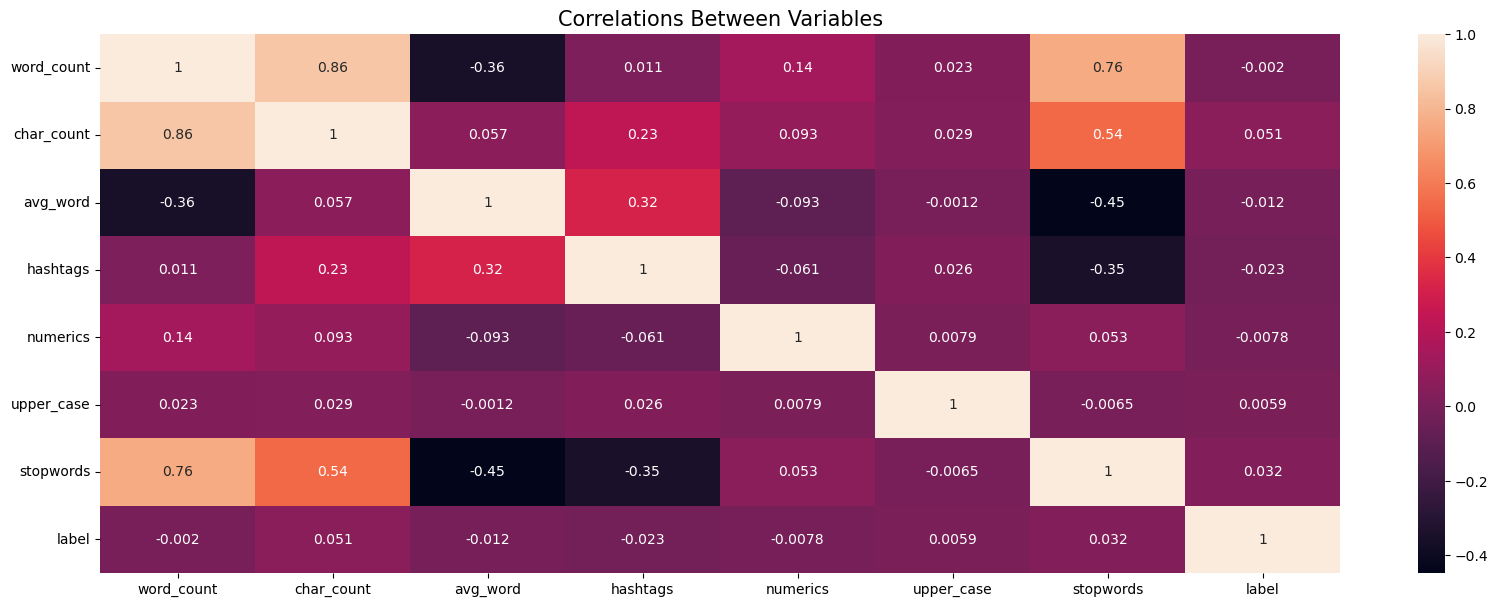

In [49]:
## visulation for correlation beetween variables
plt.figure(figsize=(20,7))
sns.heatmap(train[['word_count','char_count','avg_word','hashtags','numerics','upper_case','stopwords','label']].corr(),annot=True)
plt.title("Correlations Between Variables",size=15)
plt.show()

##### Observation:
    Although the correlations of 'label' with any of the extracted features are minimal, yet whether a tweet is positive or negetive is mostly Correlated with 'char_count' followed by 'stopwords' and 'hastags' among all.

#### Handling Imbalanced Class
    Since our target attribute is highly imbalanced, we will use RandomOverSampling technique to balance the imbalance.

In [50]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=2529)

In [51]:
y = train["label"]

In [52]:
X_ros,y_ros=ros.fit_resample(X,y)

In [53]:
X_ros.shape,y_ros.shape,X.shape,y.shape

((59440, 1000), (59440,), (31962, 1000), (31962,))

In [54]:
y_ros.value_counts()

label
0    29720
1    29720
Name: count, dtype: int64

#### Divide Train dataset

In [55]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_ros, y_ros, test_size = 0.30,random_state = 2529)

In [56]:
y_train.value_counts()

label
1    20870
0    20738
Name: count, dtype: int64

## Model Building

In [57]:
def pipeline(learner_list,train_x,train_y,test_x,test_y): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: outcome training set
       - X_test: features testing set
       - y_test: outcome testing set
    '''
    
    # Get length of Training Data:
    size = len(train_y)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(train_x,train_y)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(test_x)
        predictions_train = learner.predict(train_x)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(test_y, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(train_y, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

models = [MultinomialNB(), 
          DecisionTreeClassifier(), 
          SVC(), AdaBoostClassifier(),
         LogisticRegression(), SGDClassifier(), KNeighborsClassifier()]

### Cheaking model accuracy using TF-IDF vectors

In [60]:
from time import time
from sklearn.metrics import accuracy_score
re = pipeline(models, X_train, y_train, X_test,y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Prediction Time','Accuracy: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.02 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 2.30 sec
----------------------------------------------------
Training SVC
Training SVC finished in 136.47 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 2.07 sec
----------------------------------------------------
Training LogisticRegression
Training LogisticRegression finished in 0.45 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.12 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.01 sec
----------------------------------------------------


In [61]:
results.sort_values(by = 'Accuracy: Test', inplace = True, ascending = False)

In [62]:
results.reset_index(drop = True)

Algorithm  Accuracy: Test  Prediction Time  Accuracy: Train  \
0                     SVC        0.960745        51.793538         0.970486   
1  DecisionTreeClassifier        0.939715         0.051949         0.974764   
2      LogisticRegression        0.879542         0.003003         0.887498   
3           SGDClassifier        0.871747         0.003997         0.881129   
4    KNeighborsClassifier        0.866476        73.035187         0.904225   
5           MultinomialNB        0.860868         0.008214         0.869160   
6      AdaBoostClassifier        0.760375         0.602039         0.764012   

   Training Time  
0     136.468735  
1       2.303333  
2       0.450005  
3       0.117666  
4       0.007010  
5       0.018470  
6       2.069316

###### Clearly we can see SVC() has highest test accuracy

#### So, among all the classification model we choose Support Vector Classification as our training model

##### Here's a brief description of how SVC works:

###### Input data: 
    SVC takes as input a set of labeled training data, where each data point has a set of features and is assigned to one of the predefined classes.

###### Feature transformation: 
    If the data is not linearly separable in its original feature space, SVC can apply a kernel trick to map the input features into a higher-dimensional space. This transformation enables SVC to find a linear decision boundary in the transformed space.

###### Margin maximization: 
    SVC identifies the optimal decision boundary by finding the hyperplane that maximizes the margin between the classes. The margin is defined as the perpendicular distance between the decision boundary and the closest data points, known as support vectors.

###### Soft margin and regularization: 
    In scenarios where the data is not perfectly separable, SVC allows for a soft margin, which permits a certain number of misclassified data points. Additionally, regularization parameters can be used to control the balance between maximizing the margin and allowing for misclassifications.

###### Classification: 
    Once the optimal decision boundary is determined, SVC can classify new, unseen data points based on which side of the decision boundary they fall.
    
    

    SVC has several advantages. It can handle datasets with a high number of dimensions and is effective in cases where the data may not be linearly separable. SVC is also less sensitive to outliers compared to some other algorithms. However, SVC may have longer training times, especially with larger datasets.

    Overall, SVC is a powerful classification algorithm widely used in various domains, including text classification, image recognition, and bioinformatics, among others.

In [63]:
svc=SVC(probability=True)
model=svc.fit(X_train,y_train)
svc_pred=model.predict(X_test)
print(classification_report(y_test,svc_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9903    0.9312    0.9598      8982
           1     0.9342    0.9907    0.9616      8850

    accuracy                         0.9607     17832
   macro avg     0.9622    0.9610    0.9607     17832
weighted avg     0.9624    0.9607    0.9607     17832



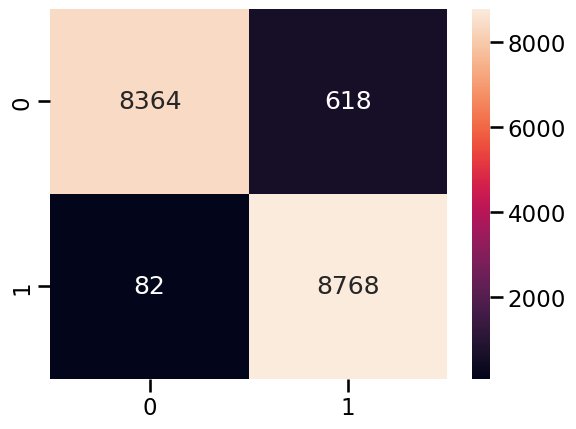

In [64]:
cm = confusion_matrix(y_test, svc_pred)
sns.set_context('talk')
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#### SVM classifier parameter tuning

In [66]:
from sklearn.model_selection import GridSearchCV
param_grid={'C':[1,5],
           'gamma':[10,15,20],
           'kernel':['rbf'],
           'class_weight':['balanced']}
gs=GridSearchCV(svc,param_grid,refit=True,verbose=2,cv=2)
gs.fit(X_train,y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ...C=1, class_weight=balanced, gamma=10, kernel=rbf; total time= 7.7min
[CV] END ...C=1, class_weight=balanced, gamma=10, kernel=rbf; total time= 6.2min
[CV] END ...C=1, class_weight=balanced, gamma=15, kernel=rbf; total time= 6.1min
[CV] END ...C=1, class_weight=balanced, gamma=15, kernel=rbf; total time= 6.1min
[CV] END ...C=1, class_weight=balanced, gamma=20, kernel=rbf; total time= 6.2min
[CV] END ...C=1, class_weight=balanced, gamma=20, kernel=rbf; total time= 6.3min
[CV] END ...C=5, class_weight=balanced, gamma=10, kernel=rbf; total time= 5.6min
[CV] END ...C=5, class_weight=balanced, gamma=10, kernel=rbf; total time= 5.6min
[CV] END ...C=5, class_weight=balanced, gamma=15, kernel=rbf; total time= 5.8min
[CV] END ...C=5, class_weight=balanced, gamma=15, kernel=rbf; total time= 5.7min
[CV] END ...C=5, class_weight=balanced, gamma=20, kernel=rbf; total time= 5.7min
[CV] END ...C=5, class_weight=balanced, gamma=20,

GridSearchCV(cv=2, estimator=SVC(probability=True),
             param_grid={'C': [1, 5], 'class_weight': ['balanced'],
                         'gamma': [10, 15, 20], 'kernel': ['rbf']},
             verbose=2)

In [67]:
# Printing best values of estimators
print(gs.best_estimator_)

SVC(C=1, class_weight='balanced', gamma=20, probability=True)


In [68]:
pred=gs.predict(X_test)

In [69]:
print(classification_report(y_test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.9959    0.9519    0.9734      8982
           1     0.9533    0.9960    0.9742      8850

    accuracy                         0.9738     17832
   macro avg     0.9746    0.9740    0.9738     17832
weighted avg     0.9748    0.9738    0.9738     17832



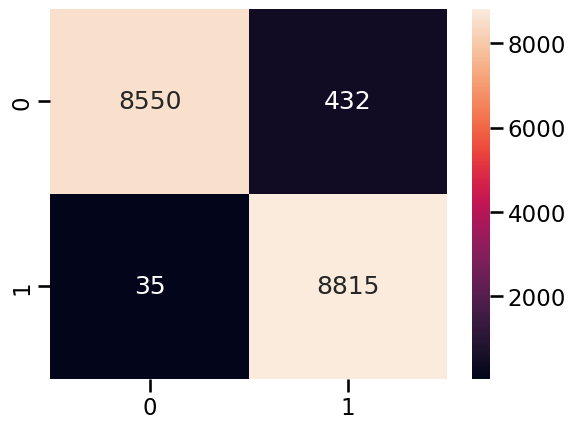

In [70]:
cm = confusion_matrix(y_test,pred)
sns.set_context('talk')
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Observation:
###### We can see that the values of precision, recall, f1 score and accuracy have been improved, which reflects in significant decrease of the value of False-Positives and False-Negetives numbers, which represents the improvement of our model.

### Predicting label of target dataset using SVC model(with parameter tuning)

In [72]:
# Converting tweets from target data to vectors
tfidf = TfidfVectorizer(max_features=1000,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
X_target = tfidf.fit_transform(target['clean_tweet'])

In [73]:
X_target.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
# Classifying and displaying first 100 tweets
gs.predict(X_target)[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [75]:
target_label=gs.predict(X_target)

In [78]:
# Creating new feature column "target_label" containing type of tweet(positive or negetive)
target['target_label']=target_label

In [79]:
target.head()

id                                              tweet  word_count  \
0  31963  #studiolife #aislife #requires #passion #dedic...          12   
1  31964   @user #white #supremacists want everyone to s...          20   
2  31965  safe ways to heal your #acne!!    #altwaystohe...          15   
3  31966  is the hp and the cursed child book up for res...          24   
4  31967    3rd #bihday to my amazing, hilarious #nephew...          18   

   char_count  avg_word  hashtags  numerics  upper_case  stopwords  \
0          90  8.777778         7         0           0          1   
1         101  5.125000         4         0           0          4   
2          71  6.333333         4         0           0          2   
3         142  5.409091         3         0           0          8   
4          93  5.066667         2         0           0          4   

                                         clean_tweet  target_label  
0  studiolife aislife requires passion dedication...             1  
1  white supremacist want everyone see new bird m...             0  
2   safe way heal acne altwaystoheal healthy healing             0  
3  hp cursed child book reservation already yes h...             0  
4  rd bihday amazing hilarious nephew eli ahmir u...             0

In [80]:
target['target_label']=target['target_label'].map({0:'positive',1:'negetive'})

In [81]:
target.head()

id                                              tweet  word_count  \
0  31963  #studiolife #aislife #requires #passion #dedic...          12   
1  31964   @user #white #supremacists want everyone to s...          20   
2  31965  safe ways to heal your #acne!!    #altwaystohe...          15   
3  31966  is the hp and the cursed child book up for res...          24   
4  31967    3rd #bihday to my amazing, hilarious #nephew...          18   

   char_count  avg_word  hashtags  numerics  upper_case  stopwords  \
0          90  8.777778         7         0           0          1   
1         101  5.125000         4         0           0          4   
2          71  6.333333         4         0           0          2   
3         142  5.409091         3         0           0          8   
4          93  5.066667         2         0           0          4   

                                         clean_tweet target_label  
0  studiolife aislife requires passion dedication...     negetive  
1  white supremacist want everyone see new bird m...     positive  
2   safe way heal acne altwaystoheal healthy healing     positive  
3  hp cursed child book reservation already yes h...     positive  
4  rd bihday amazing hilarious nephew eli ahmir u...     positive

In [82]:
target[['tweet','target_label']]

tweet target_label
0      #studiolife #aislife #requires #passion #dedic...     negetive
1       @user #white #supremacists want everyone to s...     positive
2      safe ways to heal your #acne!!    #altwaystohe...     positive
3      is the hp and the cursed child book up for res...     positive
4        3rd #bihday to my amazing, hilarious #nephew...     positive
...                                                  ...          ...
17192  thought factory: left-right polarisation! #tru...     positive
17193  feeling like a mermaid ð #hairflip #neverre...     positive
17194  #hillary #campaigned today in #ohio((omg)) &am...     positive
17195  happy, at work conference: right mindset leads...     positive
17196  my   song "so glad" free download!  #shoegaze ...     positive

[17197 rows x 2 columns]

In [83]:
target['target_label'].value_counts()

target_label
positive    16388
negetive      809
Name: count, dtype: int64

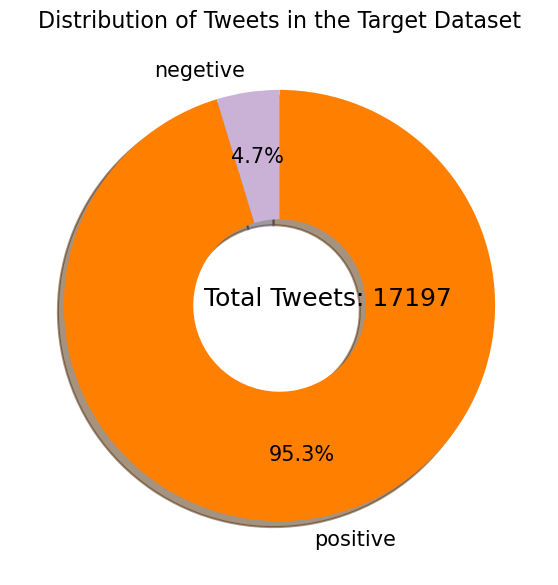

In [84]:
plt.figure(figsize = (7,7))
sorted_counts = target['target_label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(target.shape[0]))
plt.title('Distribution of Tweets in the Target Dataset', fontsize = 16);

## Conclusion:

Based on the sentiment analysis of the given dataset we can conclude  that overall most of tweets are positive(95.3%).

### Explaination
In this classification problem, the train data is consists of tweets as input.

With only two classes in the objective feature (0: positive, 1: negetive), it was a binary classification challenge. The classes were imbalanced and the models were predicting all 0s in the target feature. We had employed the over-sampling technique to address this.


We have extracted multiple features( word_count','char_count','avg_word','hashtags','numerics','upper_case','stopwords') for better understanding of nature of tweets. Although the correlations of 'label' with any of the extracted features are minimal, yet whether a tweet is positive or negetive is mostly Correlated with 'char_count' followed by 'stopwords' and 'hastags' among all.




We have created a pipeline to compare testing and training accauracy of seven different models, then we choose top performing model among them, which is SVC(), tuned parameters of SVC(), calculated Classification report and AUC_Score, which are pretty impressive. Also the difference between training and testing accuracy is very less(~1%), that shows the model is not overfitting.

Finally, using SVC model we have done classification of target tweets into positive(~95%) and negetive(5%) class. 


### Scope for Improvement

To improve the model performance and to get higher accuracy the below things can be done:

1.A model's performance increases with increase in data. If we can increase our training data we can achieve higher accuracy.

2.Experimenting with under-sampling to see whether there is any change in model performance.

3.Instead of TFIDF, Word2Vec can be used to achieve better performence of model. Word2Vec is a popular word embedding technique that represents words as dense vectors in a continuous vector space. These word embeddings capture semantic and contextual information about words based on their surrounding context in a large corpus of text.

4.Using deep learning models like RNN, CNN, Transformer models, such as BERT (Bidirectional Encoder Representations from Transformers) and its variants (e.g., RoBERTa, ALBERT), can achieved state-of-the-art performance in a range of natural language processing tasks, including sentiment analysis. 